In [1]:
# Calling the necessary libraries
import numpy as np
import pandas as pd
import random
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder

### 1. Business Problem

It is expected to compare the rule-based customer segmentation method RFM and the machine learning method KMeans for customer segmentation.

### 2. Dataset Story

The data set named Online Retail II contains the online sales transactions of a UK-based retail company between 01/12/2009 and 09/12/2011. The company's product catalog includes gift items and it is known that most of its customers are wholesalers.

### 3. Features

+ InvoiceNo: Invoice number. Unique number for each transaction, i.e. invoice. If this code starts with C, it means that the process has been cancelled.
+ StockCode: Product code. Unique number for each product.
+ Description: Product name
+ Quantity:Number of products. It indicates how many of the products on the invoices were sold.
+ InvoiceDate: Invoice date and time.
+ UnitPrice: Product price (in Sterling)
+ CustomerID: Unique customer number
+ Country: Ülke ismi. The country where the customer lives.

### 4. Tasks

In [2]:
# Load the dataset
df = pd.read_excel("datasets/online_retail_II-230817-120704.xlsx")

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df.shape

(525461, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [6]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [7]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,525461.0,10.337667,-9600.0,1.0,3.0,10.0,19152.0,107.42411
InvoiceDate,525461,2010-06-28 11:37:36.845017856,2009-12-01 07:45:00,2010-03-21 12:20:00,2010-07-06 09:51:00,2010-10-15 12:45:00,2010-12-09 20:01:00,NaN
Price,525461.0,4.688834,-53594.36,1.25,2.1,4.21,25111.09,146.126914
Customer ID,417534.0,15360.645478,12346.0,13983.0,15311.0,16799.0,18287.0,1680.811316


In [8]:
#Ranking of the most ordered products
df.groupby("Description").agg({"Quantity":"sum"}).sort_values("Quantity", ascending = False).head()

,Quantity
Description,
WHITE HANGING HEART T-LIGHT HOLDER,57733
WORLD WAR 2 GLIDERS ASSTD DESIGNS,54698
BROCADE RING PURSE,47647
PACK OF 72 RETRO SPOT CAKE CASES,46106
ASSORTED COLOUR BIRD ORNAMENT,44925


In [9]:
# How many invoices in total?
df["Invoice"].nunique()

28816

In [10]:
# Most expensive products
df.sort_values("Price", ascending = False).head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
241824,C512770,M,Manual,-1,2010-06-17 16:52:00,25111.09,17399.0,United Kingdom
241827,512771,M,Manual,1,2010-06-17 16:53:00,25111.09,NaN,United Kingdom
320581,C520667,BANK CHARGES,Bank Charges,-1,2010-08-27 13:42:00,18910.69,NaN,United Kingdom
517953,C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:04:00,13541.33,NaN,United Kingdom
519294,C537651,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:49:00,13541.33,NaN,United Kingdom


In [11]:
# Top 5 countries with the highest number of orders
df["Country"].value_counts().head()

Country
United Kingdom    485852
EIRE                9670
Germany             8129
France              5772
Netherlands         2769
Name: count, dtype: int64

In [12]:
# We added total expenditure as a column
df['TotalPrice'] = df['Price']*df['Quantity']

In [13]:
# How much income was generated from which country?
df.groupby("Country").agg({"TotalPrice":"sum"}).sort_values("TotalPrice", ascending = False).head()

,TotalPrice
Country,
United Kingdom,8194777.533
EIRE,352242.730
Netherlands,263863.410
Germany,196290.351
France,130769.900


In [14]:
# The oldest shopping history
df["InvoiceDate"].min()

Timestamp('2009-12-01 07:45:00')

In [15]:
# latest shopping date
df["InvoiceDate"].max()

Timestamp('2010-12-09 20:01:00')

In [16]:
# In order to make the evaluation easier, today's date was determined as January 1, 2012.
today = pd.to_datetime("2024-01-01")
today

Timestamp('2024-01-01 00:00:00')

In [17]:
# Changing the data type of the order date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate'].head()

0   2009-12-01 07:45:00
1   2009-12-01 07:45:00
2   2009-12-01 07:45:00
3   2009-12-01 07:45:00
4   2009-12-01 07:45:00
Name: InvoiceDate, dtype: datetime64[ns]

In [18]:
# Taking values greater than 0
df = df[df['Quantity'] > 0]
df = df[df['TotalPrice'] > 0]

In [19]:
# removal of observations with missing data
df.dropna(inplace = True)

In [20]:
df.isnull().sum(axis=0)

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalPrice     0
dtype: int64

In [21]:
df.shape

(407664, 9)

In [22]:
# Finding customer distribution by country
country_cust = df[['Country', 'Customer ID']].drop_duplicates()
country_cust.groupby(['Country'])['Customer ID'].agg('count').reset_index().sort_values('Customer ID', ascending=False)

,Country,Customer ID
34,United Kingdom,3969
12,Germany,67
11,France,47
28,Spain,25
21,Netherlands,22
25,Portugal,18
3,Belgium,17
29,Sweden,16
0,Australia,15
30,Switzerland,14


In [23]:
# keep UK data only
df_uk = df.query("Country=='United Kingdom'").reset_index(drop=True)
df_uk.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


##### 4.1 RFM

RFM; It consists of the first letters of the expressions Recency, Frequency and Monetary. It is a technique that helps determine marketing and sales strategies based on customers' purchasing habits.

+ Recency: Time since the customer's last purchase.
+ Frequency: Total number of purchases.
+ Monetary: The total expenditure made by the customer.

In [24]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 407664 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      407664 non-null  object        
 1   StockCode    407664 non-null  object        
 2   Description  407664 non-null  object        
 3   Quantity     407664 non-null  int64         
 4   InvoiceDate  407664 non-null  datetime64[ns]
 5   Price        407664 non-null  float64       
 6   Customer ID  407664 non-null  float64       
 7   Country      407664 non-null  object        
 8   TotalPrice   407664 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.1+ MB


In [26]:
#Finding Recency and Monetary values

df_x = df.groupby('Customer ID').agg({'TotalPrice': lambda x: x.sum(), #monetary value
                                        'InvoiceDate': lambda x: (today - x.max()).days}) #recency value

#x.max()).days; customers' last shopping date

In [27]:
# Find the frequency value per capita

df_y = df.groupby(['Customer ID','Invoice']).agg({'TotalPrice': lambda x: x.sum()})
df_z = df_y.groupby('Customer ID').agg({'TotalPrice': lambda x: len(x)}) 

In [28]:
# Creating the RFM table
rfm_table= pd.merge(df_x,df_z, on='Customer ID')

In [29]:
# Determining column names
rfm_table.rename(columns= {'InvoiceDate': 'Recency',
                          'TotalPrice_y': 'Frequency',
                          'TotalPrice_x': 'Monetary'}, inplace= True)

In [30]:
rfm_table.head()

,Monetary,Recency,Frequency
Customer ID,,,
12346.0,372.86,4934,11
12347.0,1323.32,4772,2
12348.0,222.16,4843,1
12349.0,2671.14,4812,3
12351.0,300.93,4780,1


In [31]:
# Descriptive statistics for Recency
rfm_table.Recency.describe()

count    4312.000000
mean     4860.172542
std        96.861457
min      4770.000000
25%      4787.000000
50%      4822.000000
75%      4905.000000
max      5143.000000
Name: Recency, dtype: float64

C:\Users\tzcnm\AppData\Local\Temp\ipykernel_3040\2316918659.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x)


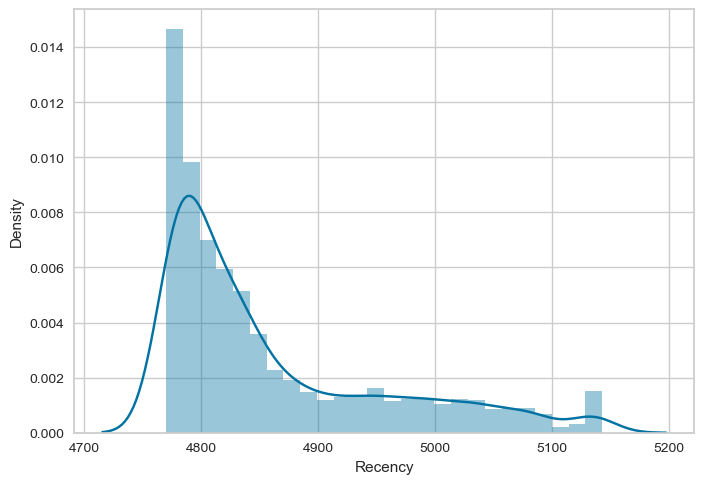

In [32]:
# Recency scatter chart
x = rfm_table['Recency']
ax = sns.distplot(x)

In [33]:
# Descriptive statistics for Frequency
rfm_table.Frequency.describe() 

count    4312.000000
mean        4.455705
std         8.170213
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       205.000000
Name: Frequency, dtype: float64

C:\Users\tzcnm\AppData\Local\Temp\ipykernel_3040\3758993304.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x)


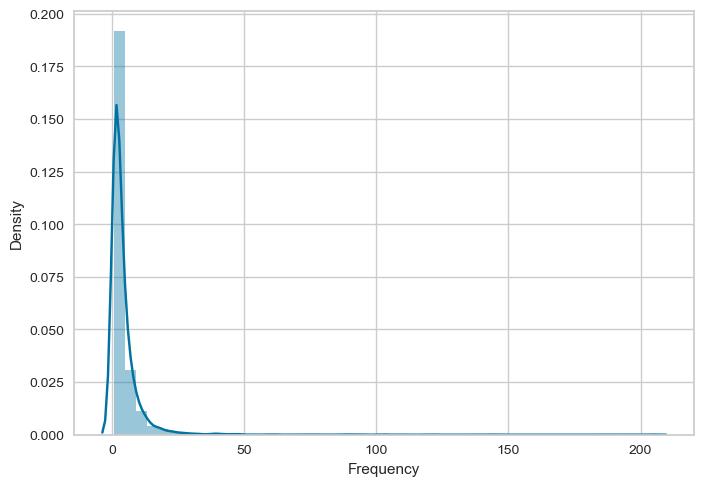

In [34]:
# Frequency scatter plot, retrieving observations with Frequency values less than 1000

x = rfm_table.query('Frequency < 1000')['Frequency']
ax = sns.distplot(x)

In [35]:
# Descriptive statistics for monetary
rfm_table.Monetary.describe()

count      4312.000000
mean       2048.238236
std        8914.481280
min           2.950000
25%         307.987500
50%         706.020000
75%        1723.142500
max      349164.350000
Name: Monetary, dtype: float64

C:\Users\tzcnm\AppData\Local\Temp\ipykernel_3040\95117821.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x)


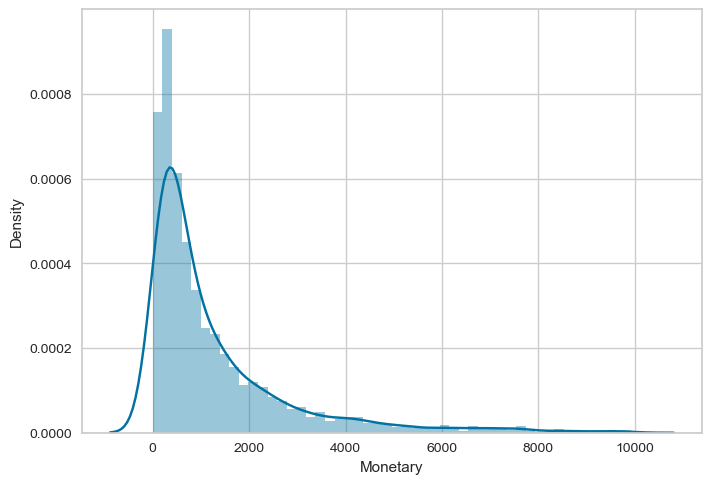

In [36]:
# Monatary scatter plot, retrieving observations with Monetary value less than 10000
x = rfm_table.query('Monetary < 10000')['Monetary']
ax = sns.distplot(x)

In [37]:
# The process of dividing into four parts using quarters

quantiles = rfm_table.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles

{'Monetary': {0.25: 307.9875, 0.5: 706.02, 0.75: 1723.1425},
 'Recency': {0.25: 4787.0, 0.5: 4822.0, 0.75: 4905.0},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0}}

##### 4.2 K-Means Segmentation

In [38]:
# Before proceeding with the clustering process, standardization must be carried out.
sc = MinMaxScaler((0,1))
x_scale = sc.fit_transform(rfm_table)
data_scale = pd.DataFrame(x_scale)

C:\Users\tzcnm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tzcnm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tzcnm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tzcnm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

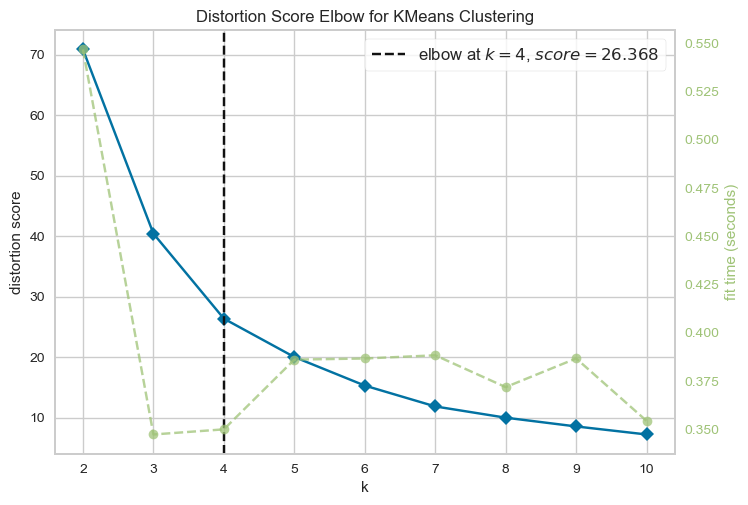

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [39]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2,11))
elbow.fit(data_scale)
elbow.show()

In [40]:
elbow.elbow_value_

4

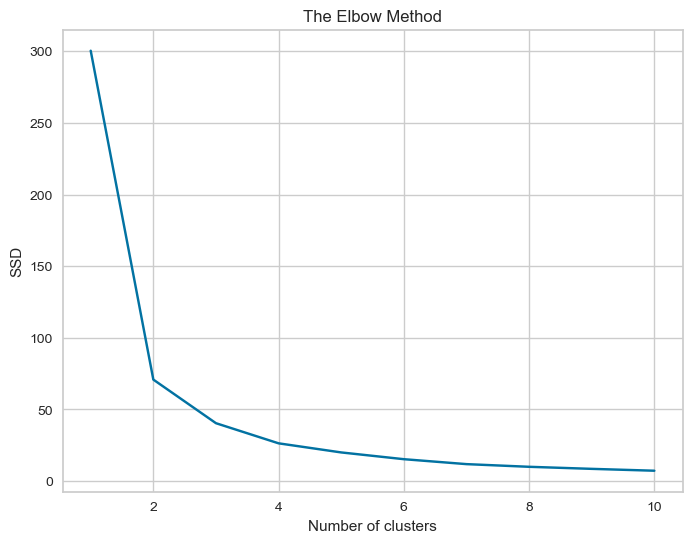

In [41]:
# Determining the number of clusters with a different graphical representation
plt.figure(figsize=(8,6))
ssd = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i,n_init=10, max_iter = 300)
    kmeans.fit(data_scale)
    ssd.append(kmeans.inertia_)
plt.plot(range(1, 11), ssd)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSD')
plt.show()

###### Interpretation of the Graph
According to the results in the graph, we observe that the SSD value decreases as the number of clusters increases. However, after a certain point, we see that the SSD value does not decrease too much. According to these results, we can get better results if we interpret the number of clusters as 3 or 4.

In [42]:
# Creation of final clusters

kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(data_scale)
cluster = kmeans.predict(data_scale)

C:\Users\tzcnm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [43]:
df1 = pd.DataFrame(rfm_table)
df1['cluster'] = cluster
df1['cluster'].value_counts()

cluster
0    2057
3    1151
2     630
1     474
Name: count, dtype: int64

In [44]:
# For clusters to start from 1
df1["cluster"] = df1["cluster"] + 1
df1["cluster"].head()

Customer ID
12346.0    3
12347.0    1
12348.0    4
12349.0    1
12351.0    1
Name: cluster, dtype: int32

In [45]:
df1.head()

,Monetary,Recency,Frequency,cluster
Customer ID,,,,
12346.0,372.86,4934,11,3
12347.0,1323.32,4772,2,1
12348.0,222.16,4843,1,4
12349.0,2671.14,4812,3,1
12351.0,300.93,4780,1,1


In [46]:
# Average values of the clusters
df1.groupby('cluster').mean()

,Monetary,Recency,Frequency
cluster,,,
1,3257.084273,4788.775401,6.654837
2,544.810281,5073.476793,1.369198
3,720.482303,4956.241270,2.063492
4,1233.741964,4847.344049,3.105995


#### Summary
Within the scope of the study, the data set was first analyzed. Then, Monetary, Recency, Frequency values were found with RFM analysis.  In line with the results obtained with RFM, the number of clusters was determined as 4 with the Elbow method. And finally, numerical variables were reduced to 4 clusters by applying clustering analysis with K-Means.